<a href="https://colab.research.google.com/github/turna1/GenAI/blob/main/mcrlab_data_geenrator_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# @title install packages
from zipfile import ZipFile
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError, KLDivergence
from tensorflow.keras.optimizers import Adam
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split


In [ ]:
# @title
def unzipper (path):
  file_name = path
  with ZipFile(file_name, 'r') as zip:
    zip.extractall()
  print('Done')

In [ ]:
# @title  load dataset (you must upload it here in content)
path = "/content/anemia dataset-20231004T235516Z-001.zip" # @param {type:"string"}
unzipper(path)

Done


In [10]:
# @title cutomize input for  your dataset
dataset_path = "/content/anemia dataset" # @param {type:"string"}
defect_classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print("your dataset has", len(defect_classes),'classes :', defect_classes)

your dataset has 2 classes : ['anemic', 'non-anemic']


In [20]:
# @title perform preprocessing (if you are interested in modifying the dimensions please go to show code and make changes)
# Define the image dimensions
image_width = 224
image_height = 224
num_channels = 1  # Change the number of channels to 1 for grayscale images

# Initialize empty lists to store the images and labels
images = []
labels = []

# Iterate over each defect class folder
for i, defect_class in enumerate(defect_classes):
    class_path = os.path.join(dataset_path, defect_class)

    # Iterate over each image in the defect class folder
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)

        # Load the image with size limit
        with Image.open(image_path) as image:
            # Convert the image to grayscale
            image = image.convert('L')

            # Resize the image to the desired dimensions
            image = image.resize((image_width, image_height))

            # Convert the image to numpy array and normalize pixel values
            image_array = np.array(image) / 255.0

            # Append the image and label to the respective lists
            images.append(image_array)
            labels.append(i)  # Use the index as the label for each defect class

# Convert the image and label lists to numpy arrays
x = np.array(images)
y = np.array(labels)

# Perform train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Print the shapes of the training and testing data arrays
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (128, 224, 224)
y_train shape: (128,)
x_test shape: (55, 224, 224)
y_test shape: (55,)


Test split =0.3 because the defect bottom class has very lower sample and with 80:20 split test was empty. so we kept the test split =0.3


Data visualization


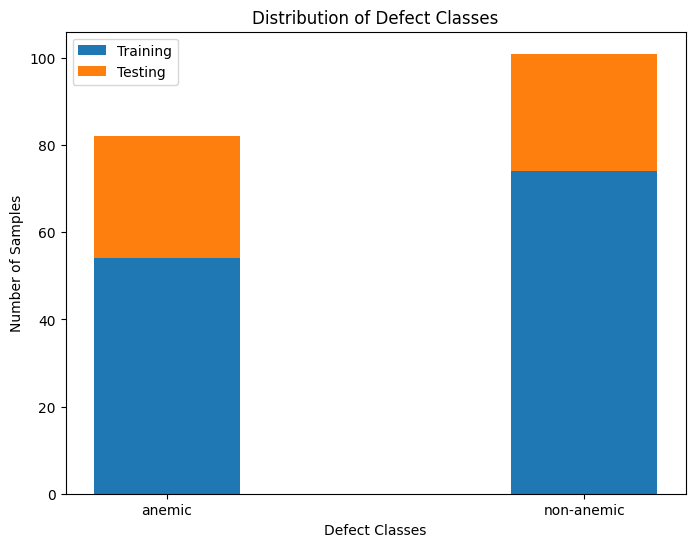

In [15]:
# @title Visualize data distribution per class
import matplotlib.pyplot as plt

# Calculate the number of samples in each class for training data
train_class_counts = [len(y_train[y_train == i]) for i in range(len(defect_classes))]

# Calculate the number of samples in each class for testing data
test_class_counts = [len(y_test[y_test == i]) for i in range(len(defect_classes))]

# Plotting the class distribution
fig, ax = plt.subplots(figsize=(8, 6))
x = range(len(defect_classes))
width = 0.35

ax.bar(x, train_class_counts, width, label='Training')
ax.bar(x, test_class_counts, width, bottom=train_class_counts, label='Testing')

ax.set_xlabel('Defect Classes')
ax.set_ylabel('Number of Samples')
ax.set_xticks(x)
ax.set_xticklabels(defect_classes)
ax.set_title('Distribution of Defect Classes')

ax.legend()
plt.show()


In [ ]:
# @title show samples per class
import random
import matplotlib.pyplot as plt

# Select one image per defect class
selected_images = []
selected_labels = []

for i in range(len(defect_classes)):
    class_indices = np.where(y == i)[0]
    selected_index = random.choice(class_indices)
    selected_images.append(images[selected_index])
    selected_labels.append(y[selected_index])

# Plotting the selected images
num_images_to_display = len(defect_classes)
fig, axes = plt.subplots(1, num_images_to_display, figsize=(12, 4))

for i, ax in enumerate(axes):
    ax.imshow(selected_images[i], cmap='gray')
    ax.set_title(f"Class: {defect_classes[selected_labels[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [22]:
# @title initialize the model. (For fine-tuning click on show code)
import torch
import torch.nn as nn

# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(num_channels, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * (image_width // 4) * (image_height // 4), latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * (image_width // 4) * (image_height // 4)),
            nn.Unflatten(1, (32, image_width // 4, image_height // 4)),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, num_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed

# Define the hyperparameters
latent_dim = 64
batch_size = 16
learning_rate = 0.001
num_epochs = 100


In [23]:
# @title keep running for few more setups
from torch.utils.data import Dataset

# Define the dataset class
class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        return torch.from_numpy(image).unsqueeze(0).float()


In [24]:
# @title
from torch.utils.data import DataLoader

# Create dataloaders for training and testing data
train_dataset = ImageDataset(x_train)
test_dataset = ImageDataset(x_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [25]:
# @title optimize the model
import torch.optim as optim

# Initialize the VAE model
vae = VAE(latent_dim)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)


In [26]:
# @title start training
# Training loop3
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0.0

    for batch_images in train_dataloader:
        optimizer.zero_grad()

        # Preprocess the batch_images to have the correct number of channels
        batch_images_preprocessed = torch.unsqueeze(batch_images, 2)  # Add a channel dimension

        # Reshape the batch_images_preprocessed to have the correct dimensions
        batch_images_preprocessed = batch_images_preprocessed.view(-1, num_channels, image_height, image_width)

        # Forward pass
        reconstructions = vae(batch_images_preprocessed)

        # Compute the reconstruction loss
        loss = criterion(reconstructions, batch_images_preprocessed)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_images.size(0)

    train_loss /= len(train_dataloader.dataset)

    # Print the training loss for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")


Epoch [1/100], Train Loss: 0.0518
Epoch [2/100], Train Loss: 0.0239
Epoch [3/100], Train Loss: 0.0182
Epoch [4/100], Train Loss: 0.0156
Epoch [5/100], Train Loss: 0.0142
Epoch [6/100], Train Loss: 0.0131
Epoch [7/100], Train Loss: 0.0125
Epoch [8/100], Train Loss: 0.0117
Epoch [9/100], Train Loss: 0.0110
Epoch [10/100], Train Loss: 0.0104
Epoch [11/100], Train Loss: 0.0097
Epoch [12/100], Train Loss: 0.0093
Epoch [13/100], Train Loss: 0.0089
Epoch [14/100], Train Loss: 0.0087
Epoch [15/100], Train Loss: 0.0084
Epoch [16/100], Train Loss: 0.0082
Epoch [17/100], Train Loss: 0.0080
Epoch [18/100], Train Loss: 0.0078
Epoch [19/100], Train Loss: 0.0075
Epoch [20/100], Train Loss: 0.0073
Epoch [21/100], Train Loss: 0.0071
Epoch [22/100], Train Loss: 0.0068
Epoch [23/100], Train Loss: 0.0064
Epoch [24/100], Train Loss: 0.0056
Epoch [25/100], Train Loss: 0.0047
Epoch [26/100], Train Loss: 0.0037
Epoch [27/100], Train Loss: 0.0030
Epoch [28/100], Train Loss: 0.0025
Epoch [29/100], Train Loss: 0

In [ ]:
# @title obtain test accuracy
# Test the VAE on the testing data
vae.eval()
test_loss = 0.0

for batch_images in test_dataloader:
    with torch.no_grad():
        reconstructions = vae(batch_images)
        loss = criterion(reconstructions, batch_images)

        test_loss += loss.item() * batch_images.size(1)

test_loss /= len(test_dataloader.dataset)

# Print the testing loss
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.0020


In [27]:
# @title Default title text
import os
import random
import shutil
import torch
import torchvision.transforms as transforms
from PIL import Image

def reconstruct_images(dataset_path, defect_classes, reconstructed_path, vae_model, num_images_per_sample):
    Image.MAX_IMAGE_PIXELS = None
    # Create a directory to save the reconstructed and original images
    os.makedirs(reconstructed_path, exist_ok=True)

    # Set the model to evaluation mode
    vae_model.eval()

    # Define the transformation to apply to the images
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((224, 224)),  # Resize the image
        transforms.ToTensor()
    ])

    # Reconstruct images for each class
    for defect_class in defect_classes:
        class_path = os.path.join(dataset_path, defect_class)
        reconstructed_class_path = os.path.join(reconstructed_path, defect_class + "_reconstructed")
        os.makedirs(reconstructed_class_path, exist_ok=True)

        # Get the list of image files in the class folder
        image_files = os.listdir(class_path)

        # Shuffle the image files randomly
        random.shuffle(image_files)

        # Select up to num_images_per_sample images (or less if there are fewer than num_images_per_sample images)
        num_samples = len(image_files)
        num_images = num_images_per_sample * num_samples

        # Reconstruct and save images for each sample
        for i in range(num_images):
            sample_index = i // num_images_per_sample  # Determine the index of the sample
            sample_image_index = i % num_images_per_sample  # Determine the index of the image within the sample
            image_file = image_files[sample_index]
            image_path = os.path.join(class_path, image_file)

            # Load and preprocess the image
            image = Image.open(image_path)
            image = transform(image)

            # Reshape the image to match the expected input shape of the VAE model
            image = image.unsqueeze(0)  # Add a batch dimension

            # Reconstruct the image using the VAE model
            with torch.no_grad():
                reconstructed_image = vae_model(image)

            # Convert the reconstructed image tensor to a PIL image
            reconstructed_image = transforms.ToPILImage()(reconstructed_image.squeeze())

            # Define a unique name for the reconstructed image
            reconstructed_name = f'reconstructed_{sample_image_index}_{image_file}'

            # Save the reconstructed image as a JPG file
            reconstructed_file_path = os.path.join(reconstructed_class_path, reconstructed_name)
            reconstructed_image.save(reconstructed_file_path, 'JPEG')

            # Save the original image as a JPG file
            original_name = f'original_{sample_image_index}_{image_file}'
            original_file_path = os.path.join(reconstructed_class_path, original_name)
            image = transforms.ToPILImage()(image.squeeze())
            image.save(original_file_path, 'JPEG')
            print("reconstruction is done")


In [28]:
# @title Generate the dataset
num_images_per_sample = 5 # @param {type:"number"}

# Create a directory to save the reconstructed and original images
reconstructed_path = '/content/NN_reconstructed_images'

# Set the model to evaluation mode
vae_model = vae
vae_model.eval()

# Call the function to reconstruct and save the images
reconstruct_images(dataset_path, defect_classes, reconstructed_path, vae_model, num_images_per_sample)


reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruction is done
reconstruct

In [ ]:
# @title  save the synthetic (generated) dataset as zip. Download from the content
# Path to the reconstructed folder
reconstructed_path = '/content/NN_reconstructed_images'

# Path for the output zip file
output_zip_file = '/content/NNreconstructed_images.zip'

# Create a zip file of the reconstructed folder
shutil.make_archive(output_zip_file, 'zip', reconstructed_path)

'/content/NNreconstructed_images.zip.zip'